# Import Semua Packages/Library yang Digunakan

In [3]:
# Libraries umum
import shutil
import zipfile
import random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Visualisasi
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Pemrosesan data gambar
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback,
    EarlyStopping,
    ReduceLROnPlateau,
)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [6]:
ROOT_PATH = '/kaggle/input/food11-image-dataset'
training_path = f'{ROOT_PATH}/training'
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

In [7]:
from PIL import Image
import os

def print_images_resolution(directory):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue  # skip file non-folder

        unique_sizes = set()
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except:
                print(f"⚠️ gagal buka: {img_path}")

        print("Ukuran unik:")
        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal semua gambar: {total_images}")

# Pakai path yang benar di Kaggle
ROOT_PATH = '/kaggle/input/food11-image-dataset'

training_path   = f'{ROOT_PATH}/training'
validation_path = f'{ROOT_PATH}/validation'
evaluation_path = f'{ROOT_PATH}/evaluation'

# Jalankan fungsi untuk cek dataset
print("=== Training ===")
print_images_resolution(training_path)

print("\n=== Validation ===")
print_images_resolution(validation_path)

print("\n=== Evaluation ===")
print_images_resolution(evaluation_path)

=== Training ===
Fried food: 848
Ukuran unik:
- (512, 342)
- (506, 512)
- (512, 287)
- (341, 512)
- (385, 512)
- (512, 473)
- (512, 436)
- (288, 512)
- (512, 384)
- (510, 512)
- (512, 509)
- (512, 506)
- (512, 512)
- (382, 512)
- (512, 341)
- (512, 344)
- (512, 289)
- (512, 362)
- (426, 512)
- (505, 512)
- (307, 512)
- (384, 512)
- (512, 371)
- (512, 380)
- (512, 499)
- (289, 512)
- (512, 383)
- (512, 334)
- (302, 512)
- (512, 511)
- (512, 398)
- (512, 401)
- (512, 340)
- (512, 410)
- (512, 288)
- (511, 512)
- (512, 306)
- (512, 309)
- (306, 512)
- (512, 498)
- (512, 324)
- (512, 382)
- (512, 385)
- (512, 510)
- (512, 339)
---------------
Noodles-Pasta: 440
Ukuran unik:
- (512, 342)
- (512, 287)
- (508, 512)
- (640, 515)
- (600, 360)
- (512, 308)
- (397, 300)
- (288, 512)
- (512, 314)
- (512, 384)
- (510, 512)
- (512, 509)
- (512, 512)
- (382, 512)
- (800, 534)
- (450, 534)
- (600, 448)
- (512, 341)
- (475, 356)
- (512, 289)
- (512, 391)
- (600, 356)
- (600, 487)
- (512, 307)
- (384, 5

In [8]:
import os
from collections import defaultdict

data_dir = ROOT_PATH
label_counts = defaultdict(int)
total_images = 0

# Iterate through the subdirectories (training, validation, evaluation)
for split_dir in os.listdir(data_dir):
    split_dir_path = os.path.join(data_dir, split_dir)
    if os.path.isdir(split_dir_path):
        # Iterate through the label directories within each split directory
        for label_dir in os.listdir(split_dir_path):
            label_dir_path = os.path.join(split_dir_path, label_dir)
            if os.path.isdir(label_dir_path):
                num_images = len(os.listdir(label_dir_path))
                label_counts[label_dir] += num_images
                total_images += num_images

print("Jumlah gambar per label:")
for label, count in label_counts.items():
    percentage = (count / total_images) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

print(f"\nTotal semua gambar: {total_images}")

Jumlah gambar per label:
- Fried food: 1461 (8.78%)
- Noodles-Pasta: 734 (4.41%)
- Bread: 1724 (10.36%)
- Dessert: 2500 (15.02%)
- Seafood: 1505 (9.04%)
- Soup: 2500 (15.02%)
- Meat: 2206 (13.25%)
- Dairy product: 721 (4.33%)
- Vegetable-Fruit: 1172 (7.04%)
- Egg: 1648 (9.90%)
- Rice: 472 (2.84%)

Total semua gambar: 16643


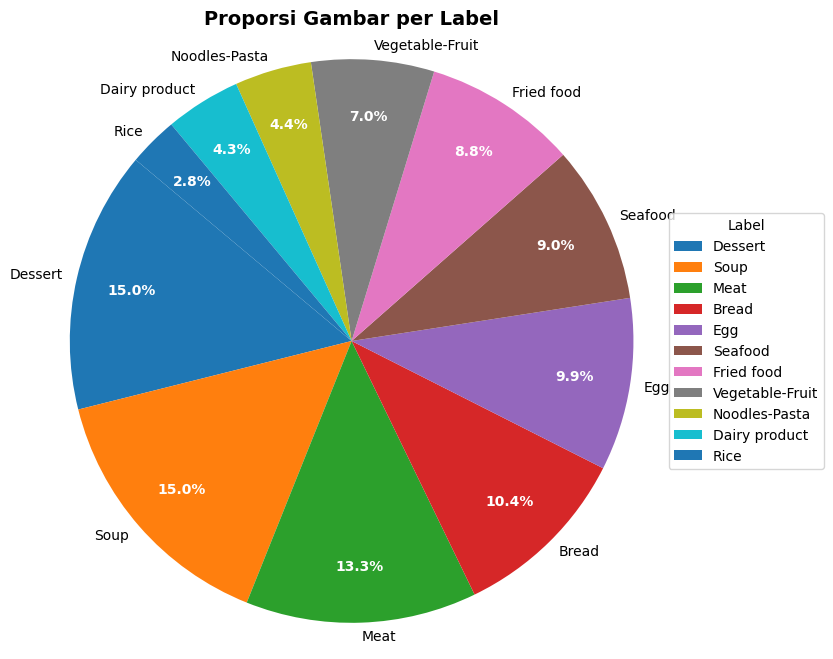

In [9]:
# Sort label biar dari terbesar ke terkecil
labels = list(label_counts.keys())
sizes = list(label_counts.values())
labels, sizes = zip(*sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(8, 8))

# Pie chart dengan pengaturan jarak
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10},
    pctdistance=0.8,    # posisi angka %
    labeldistance=1.05  # posisi label
)

# Buat teks % lebih tebal dan kontras
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.axis('equal')  
plt.title('Proporsi Gambar per Label', fontsize=14, fontweight='bold')

# Tambah legend di samping (opsional kalau label panjang)
plt.legend(wedges, labels, title="Label", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [10]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, size):
    """
    Mengubah ukuran semua gambar dalam direktori dan menyimpannya di direktori baru.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for split_dir in os.listdir(input_dir):
        split_dir_path = os.path.join(input_dir, split_dir)
        output_split_dir_path = os.path.join(output_dir, split_dir)

        if os.path.isdir(split_dir_path):
            if not os.path.exists(output_split_dir_path):
                os.makedirs(output_split_dir_path)

            for label_dir in os.listdir(split_dir_path):
                label_dir_path = os.path.join(split_dir_path, label_dir)
                output_label_dir_path = os.path.join(output_split_dir_path, label_dir)

                if os.path.isdir(label_dir_path):
                    if not os.path.exists(output_label_dir_path):
                        os.makedirs(output_label_dir_path)

                    image_files = os.listdir(label_dir_path)
                    print(f"Memproses {split_dir}/{label_dir}...")

                    for img_file in image_files:
                        img_path = os.path.join(label_dir_path, img_file)
                        output_img_path = os.path.join(output_label_dir_path, img_file)

                        try:
                            with Image.open(img_path) as img:
                                img_resized = img.resize(size)
                                img_resized.save(output_img_path)
                        except Exception as e:
                            print(f"⚠️ Gagal memproses {img_path}: {e}")

# Path di Kaggle
input_directory = ROOT_PATH 
output_directory = '/kaggle/working/food11-resized'
target_size = (224, 224)

# Jalankan resize
resize_images(input_directory, output_directory, target_size)

# Cek hasilnya
print("\nHasil tersimpan di:", output_directory)
print("Subfolder:", os.listdir(output_directory))

Memproses validation/Fried food...
Memproses validation/Noodles-Pasta...
Memproses validation/Bread...
Memproses validation/Dessert...
Memproses validation/Seafood...
Memproses validation/Soup...
Memproses validation/Meat...
Memproses validation/Dairy product...
Memproses validation/Vegetable-Fruit...
Memproses validation/Egg...
Memproses validation/Rice...
Memproses training/Fried food...
Memproses training/Noodles-Pasta...
Memproses training/Bread...
Memproses training/Dessert...
Memproses training/Seafood...
Memproses training/Soup...
Memproses training/Meat...
Memproses training/Dairy product...
Memproses training/Vegetable-Fruit...
Memproses training/Egg...
Memproses training/Rice...
Memproses evaluation/Fried food...
Memproses evaluation/Noodles-Pasta...
Memproses evaluation/Bread...
Memproses evaluation/Dessert...
Memproses evaluation/Seafood...
Memproses evaluation/Soup...
Memproses evaluation/Meat...
Memproses evaluation/Dairy product...
Memproses evaluation/Vegetable-Fruit...

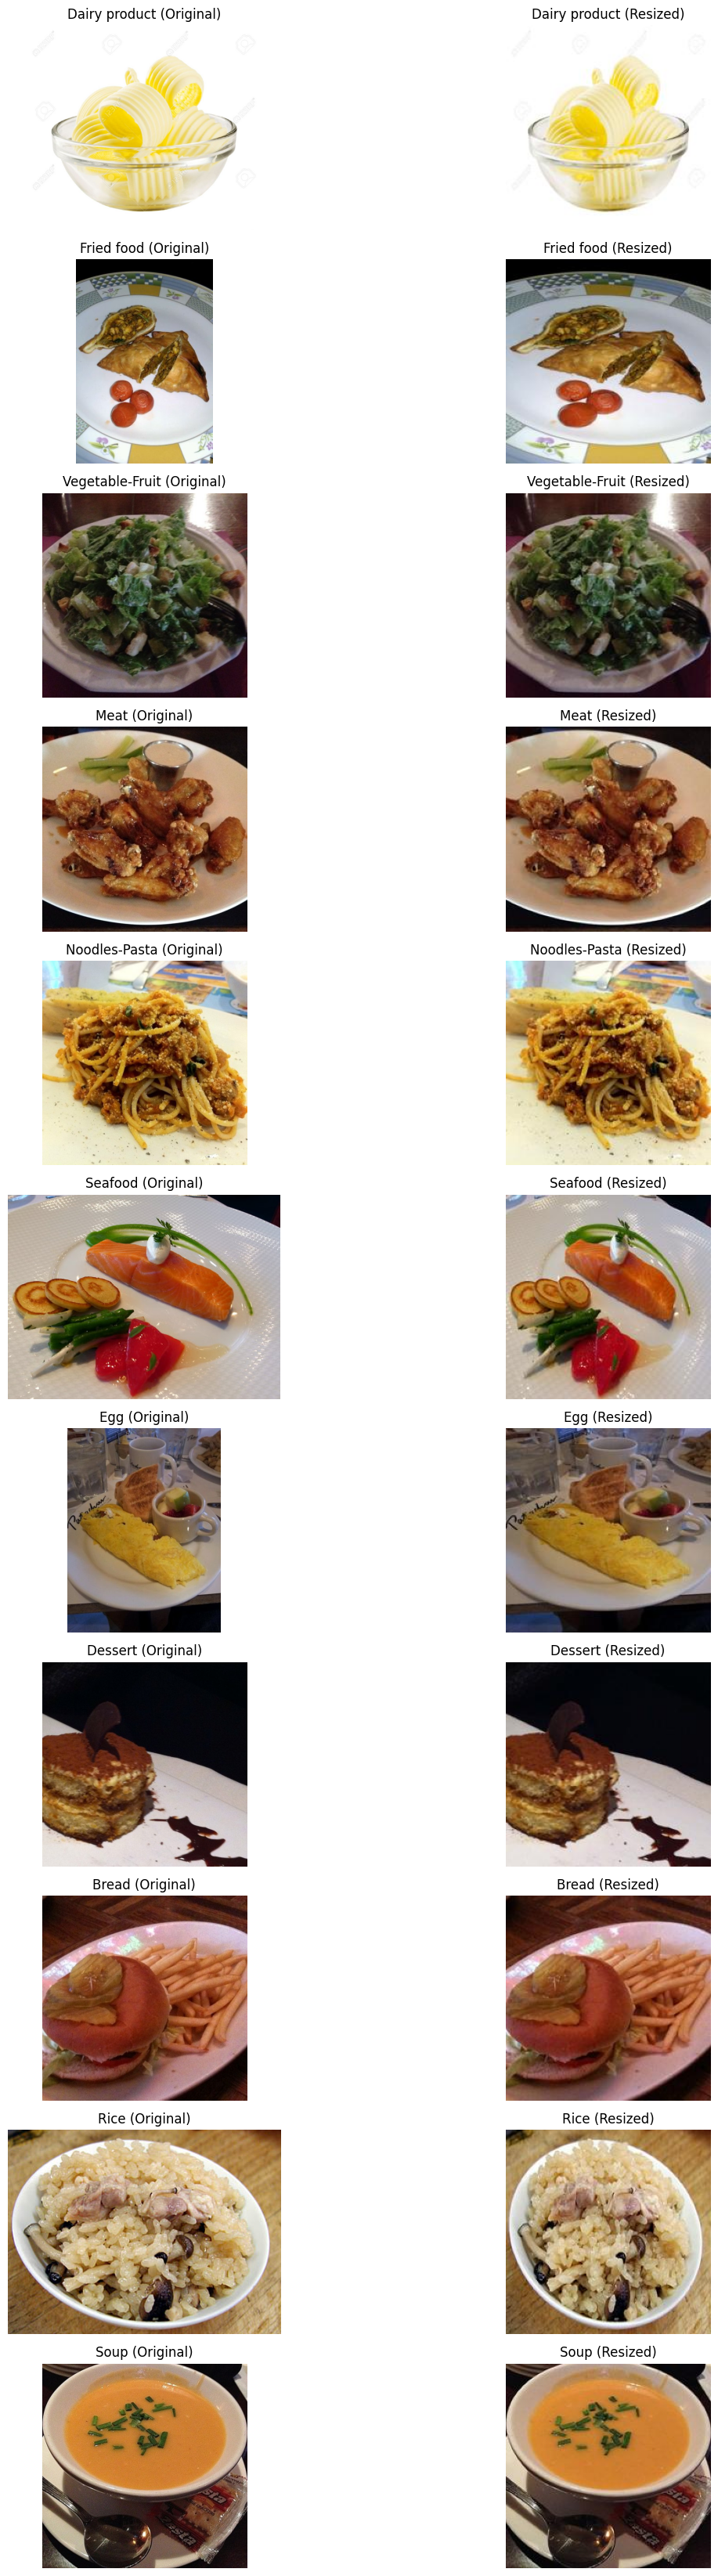

Jumlah gambar per set data setelah resize:
- validation: 3430 (20.61%)
- evaluation: 3347 (20.11%)
- training: 9866 (59.28%)

Total semua gambar di semua set: 16643


In [11]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Direktori dataset asli (input) dan yang sudah di-resize (working)
original_dir = '/kaggle/input/food11-image-dataset/training'
resized_dir = '/kaggle/working/food11-resized/training'

# Dapatkan daftar semua labels (nama sub-direktori)
labels = os.listdir(resized_dir)
labels = [label for label in labels if os.path.isdir(os.path.join(resized_dir, label))] # Filter hanya direktori

# Tentukan berapa banyak contoh gambar per label yang ingin ditampilkan
num_examples_per_label = 1

# Sesuaikan ukuran figure untuk menampilkan dua kolom (asli dan resized)
plt.figure(figsize=(15, len(labels) * 3))

for i, label in enumerate(labels):
    original_label_dir = os.path.join(original_dir, label)
    resized_label_dir = os.path.join(resized_dir, label)

    # Pastikan direktori label ada di kedua lokasi
    if not os.path.isdir(original_label_dir) or not os.path.isdir(resized_label_dir):
        print(f"⚠️ Direktori label {label} tidak ditemukan di kedua lokasi.")
        continue

    image_files = os.listdir(resized_label_dir) # Ambil nama file dari direktori resized
    # Ambil beberapa contoh gambar secara acak
    sample_images = random.sample(image_files, min(num_examples_per_label, len(image_files)))

    for j, img_file in enumerate(sample_images):
        original_img_path = os.path.join(original_label_dir, img_file)
        resized_img_path = os.path.join(resized_label_dir, img_file)

        # Tampilkan gambar asli
        try:
            img_original = Image.open(original_img_path)
            plt.subplot(len(labels), num_examples_per_label * 2, i * num_examples_per_label * 2 + j * 2 + 1)
            plt.imshow(img_original)
            plt.title(f'{label} (Original)')
            plt.axis('off')
        except Exception as e:
            print(f"⚠️ Gagal menampilkan gambar asli {original_img_path}: {e}")

        # Tampilkan gambar yang sudah di-resize
        try:
            img_resized = Image.open(resized_img_path)
            plt.subplot(len(labels), num_examples_per_label * 2, i * num_examples_per_label * 2 + j * 2 + 2)
            plt.imshow(img_resized)
            plt.title(f'{label} (Resized)')
            plt.axis('off')
        except Exception as e:
            print(f"⚠️ Gagal menampilkan gambar resized {resized_img_path}: {e}")

plt.tight_layout()
plt.show()

# Check total images after resize
data_dir = '/kaggle/working/food11-resized' # Use the resized data directory
split_counts = {}
total_images_all_splits = 0

# Iterate through the split directories (training, validation, evaluation)
for split_dir in os.listdir(data_dir):
    split_dir_path = os.path.join(data_dir, split_dir)
    if os.path.isdir(split_dir_path):
        num_images_in_split = 0
        # Iterate through the label directories within each split directory
        for label_dir in os.listdir(split_dir_path):
            label_dir_path = os.path.join(split_dir_path, label_dir)
            if os.path.isdir(label_dir_path):
                num_images_in_split += len(os.listdir(label_dir_path))
        split_counts[split_dir] = num_images_in_split
        total_images_all_splits += num_images_in_split

print("Jumlah gambar per set data setelah resize:")
for split, count in split_counts.items():
    percentage = (count / total_images_all_splits) * 100
    print(f"- {split}: {count} ({percentage:.2f}%)")

print(f"\nTotal semua gambar di semua set: {total_images_all_splits}")

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisikan path untuk training, validation, dan evaluation data
train_dir = '/kaggle/working/food11-resized/training'
validation_dir = '/kaggle/working/food11-resized/validation'
evaluation_dir = '/kaggle/working/food11-resized/evaluation'

# Definisikan parameter untuk generator
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Buat instance ImageDataGenerator untuk normalisasi
# Rescale 1./255 akan menskalakan nilai piksel dari [0, 255] menjadi [0, 1]
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,           # Rotasi gambar hingga 40 derajat
    width_shift_range=0.3,       # Pergeseran horizontal hingga 30%
    height_shift_range=0.3,      # Pergeseran vertikal hingga 30%
    shear_range=0.3,             # Transformasi geser
    zoom_range=0.3,              # Zoom hingga 30%
    horizontal_flip=True,        # Pembalikan horizontal acak
    brightness_range=[0.7, 1.3], # Variasi kecerahan
    fill_mode='nearest',         # Mode pengisian untuk area baru
    channel_shift_range=0.2      # Perubahan channel warna
)

# Validation dan evaluation hanya menggunakan normalisasi (tidak ada augmentasi)
validation_datagen = ImageDataGenerator(rescale=1./255)
evaluation_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator untuk data training, validation, dan evaluation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Karena ini adalah klasifikasi multikelas
    shuffle=True,              # Acak urutan data saat pelatihan
    seed=42                    # Untuk reproduktifitas
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,             # Tidak diacak untuk evaluasi yang konsisten
    seed=42
)

evaluation_generator = evaluation_datagen.flow_from_directory(
    evaluation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nNormalisasi data selesai dan generator telah dibuat.")
print(f"Jumlah kelas: {train_generator.num_classes}")
print(f"Jumlah batch training: {len(train_generator)}")
print(f"Jumlah batch validation: {len(validation_generator)}")
print(f"Jumlah batch evaluation: {len(evaluation_generator)}")

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.

Normalisasi data selesai dan generator telah dibuat.
Jumlah kelas: 11
Jumlah batch training: 309
Jumlah batch validation: 108
Jumlah batch evaluation: 105


In [13]:
# Menampilkan informasi tentang kelas
class_labels = list(train_generator.class_indices.keys())
print(f"Kelas yang tersedia: {class_labels}")

Kelas yang tersedia: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


Contoh hasil augmentasi data training:


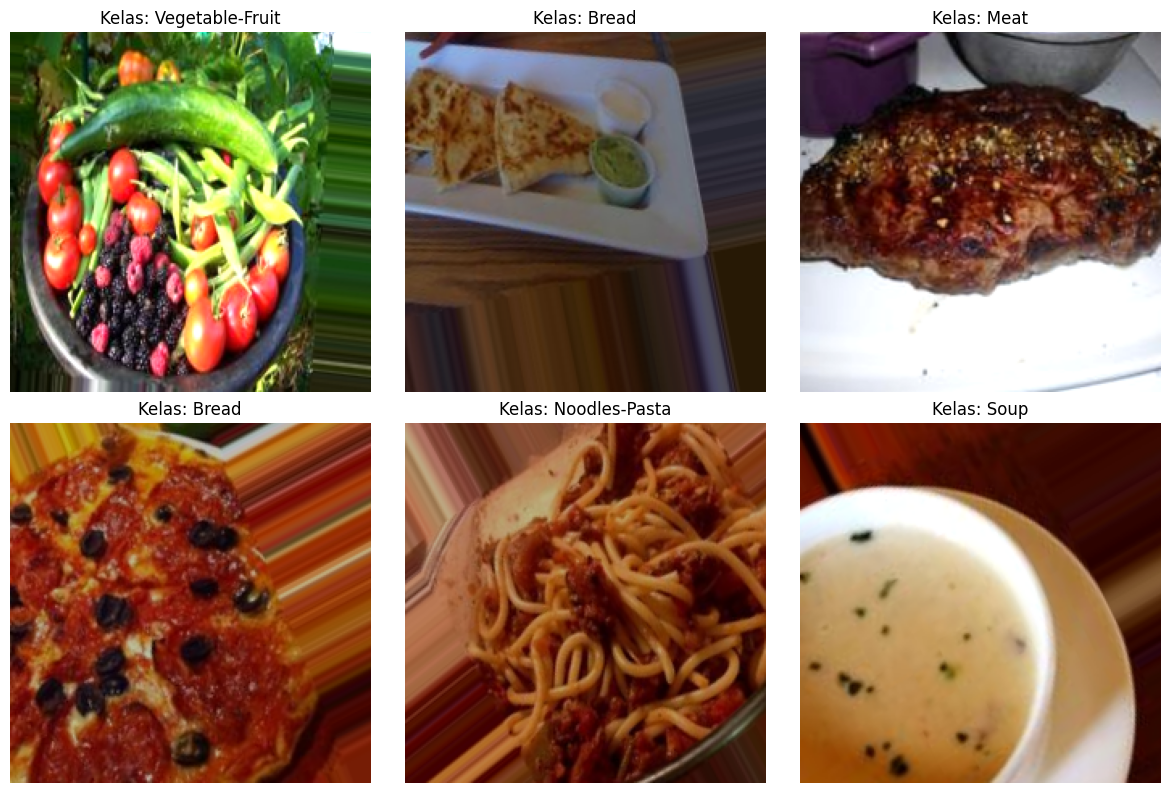

In [14]:
# Visualisasi beberapa contoh data augmentasi dari training generator
def visualize_augmentation(generator, num_samples=6):
    """
    Visualisasi contoh hasil augmentasi data
    """
    # Ambil satu batch dari generator
    batch = next(generator)
    images, labels = batch
    
    # Plot gambar
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # Kembalikan normalisasi untuk visualisasi
        img = images[i]
        # Jika gambar sudah dinormalisasi ke [0,1], gunakan langsung
        axes[i].imshow(img)
        # Dapatkan label asli
        label_idx = np.argmax(labels[i])
        label_name = class_labels[label_idx]
        axes[i].set_title(f'Kelas: {label_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualisasi augmentasi data training
print("Contoh hasil augmentasi data training:")
visualize_augmentation(train_generator)

In [15]:
# Cek bentuk data dari generator
sample_batch = next(train_generator)
print(f"Bentuk gambar batch: {sample_batch[0].shape}")
print(f"Bentuk label batch: {sample_batch[1].shape}")
print(f"Nilai piksel min: {sample_batch[0].min():.3f}, max: {sample_batch[0].max():.3f}")

# Kembalikan generator ke posisi awal
train_generator.reset()
validation_generator.reset()
evaluation_generator.reset()

Bentuk gambar batch: (32, 224, 224, 3)
Bentuk label batch: (32, 11)
Nilai piksel min: 0.000, max: 1.000


# Build Model

## Using Sequential Model

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer

enhanced_model = Sequential([
    # Input layer
    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # Blok 1 - Convolutional Layer 1
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 2 - Convolutional Layer 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 3 - Convolutional Layer 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 4 - Convolutional Layer 4
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Blok 5 - Convolutional Layer 5
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    # Flatten layer
    Flatten(),
    
    # Fully Connected Layers
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Output layer
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [29]:
enhanced_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate yang lebih rendah
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
enhanced_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 138,422,219 (528.04 MB)

 Trainable params: 138,395,387 (527.94 MB)

 Non-trainable params: 26,832 (104.81 KB)

In [31]:
# Hitung jumlah parameter
total_params = enhanced_model.count_params()
print(f"Total parameter model: {total_params:,}")

Total parameter model: 138,422,219


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Callback untuk menyimpan model terbaik
enhanced_checkpoint = ModelCheckpoint(
    'best_enhanced_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
enhanced_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Meningkatkan patience
    restore_best_weights=True,
    verbose=1
)

# Callback untuk mengurangi learning rate jika akurasi stagnan
enhanced_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Faktor pengurangan
    patience=8,  # Tunggu lebih lama sebelum mengurangi LR
    min_lr=0.00001,  # Learning rate minimum
    verbose=1
)

enhanced_callbacks = [enhanced_checkpoint, enhanced_early_stopping, enhanced_reduce_lr]

print("Callbacks telah diimplementasikan:")
for callback in enhanced_callbacks:
    print(f"- {type(callback).__name__}")

Callbacks telah diimplementasikan:
- ModelCheckpoint
- EarlyStopping
- ReduceLROnPlateau


In [33]:
# Hitung jumlah langkah per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Latih model dengan lebih banyak epoch
enhanced_history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=enhanced_callbacks,
    verbose=1
)

Epoch 1/150
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.1240 - loss: 3.2484
Epoch 1: val_accuracy improved from -inf to 0.10466, saving model to best_enhanced_model.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 299s 781ms/step - accuracy: 0.1241 - loss: 3.2479 - val_accuracy: 0.1047 - val_loss: 3.7269 - learning_rate: 1.0000e-04
Epoch 2/150
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.1925 - loss: 2.7658
Epoch 2: val_accuracy improved from 0.10466 to 0.16706, saving model to best_enhanced_model.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 198s 640ms/step - accuracy: 0.1925 - loss: 2.7654 - val_accuracy: 0.1671 - val_loss: 4.4567 - learning_rate: 1.0000e-04
Epoch 3/150
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.2418 - loss: 2.4372
Epoch 3: val_accuracy improved from 0.16706 to 0.25306, saving model to best_enhanced_model.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 199s 643ms/step - accuracy: 0.2418 - loss: 2.4371 - val_accuracy: 0.2531 - val_loss: 2.6643 - learning_rate: 1.0000e-04
Epoc

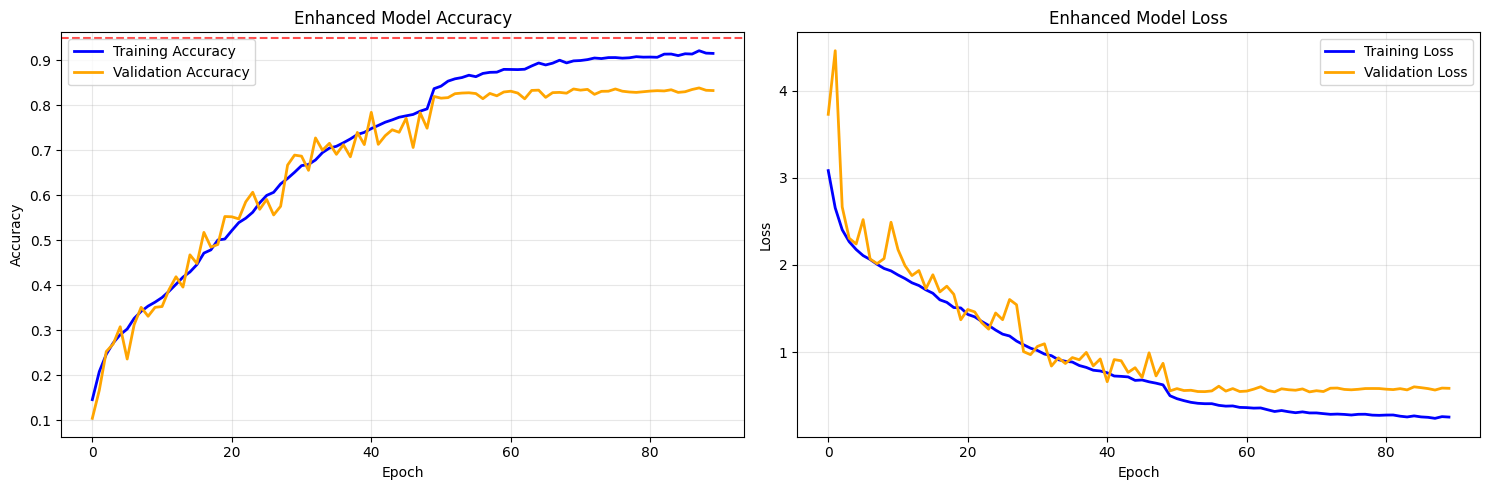

In [34]:
def plot_enhanced_training_history(history):
    """
    Plot akurasi dan loss dari proses pelatihan model yang ditingkatkan
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot akurasi
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
    ax1.set_title('Enhanced Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Tambahkan garis referensi 95%
    ax1.axhline(y=0.95, color='red', linestyle='--', label='Target 95%', alpha=0.7)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    ax2.set_title('Enhanced Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot hasil pelatihan model yang ditingkatkan
plot_enhanced_training_history(enhanced_history)

In [35]:
enhanced_evaluation_result = enhanced_model.evaluate(evaluation_generator, steps=len(evaluation_generator))
print(f"Enhanced Model - Evaluation Loss: {enhanced_evaluation_result[0]:.4f}")
print(f"Enhanced Model - Evaluation Accuracy: {enhanced_evaluation_result[1]:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.8002 - loss: 0.6407
Enhanced Model - Evaluation Loss: 0.4599
Enhanced Model - Evaluation Accuracy: 0.8602


## Using Pretrained as Based Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model initially
base_model.trainable = False

# Create the model with transfer learning
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,235,851 (16.16 MB)

 Trainable params: 1,974,283 (7.53 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

In [36]:
# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    'best_transfer_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,  # PERBAIKAN: Kurangi patience
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Callback untuk mengurangi learning rate jika akurasi stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=8,  # PERBAIKAN: Kurangi patience
    min_lr=1e-7,
    verbose=1,
    cooldown=3
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

print("Callbacks telah diimplementasikan:")
for callback in callbacks_list:
    print(f"- {type(callback).__name__}")

Callbacks telah diimplementasikan:
- ModelCheckpoint
- EarlyStopping
- ReduceLROnPlateau


In [38]:
history_phase1 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6698 - loss: 0.9999
Epoch 1: val_accuracy improved from 0.75292 to 0.77405, saving model to best_transfer_model.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 145s 468ms/step - accuracy: 0.6698 - loss: 0.9998 - val_accuracy: 0.7741 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6950 - loss: 0.9119
Epoch 2: val_accuracy improved from 0.77405 to 0.78309, saving model to best_transfer_model.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 145s 469ms/step - accuracy: 0.6950 - loss: 0.9118 - val_accuracy: 0.7831 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7261 - loss: 0.8343
Epoch 3: val_accuracy improved from 0.78309 to 0.79650, saving model to best_transfer_model.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 144s 467ms/step - accuracy: 0.7261 - loss: 0.8344 - val_accuracy: 0.7965 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 4

In [39]:
# Evaluasi pada training set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)

# Evaluasi pada testing set 
test_loss, test_accuracy = model.evaluate(evaluation_generator, verbose=1)

print(f"PHASE 1 RESULTS:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: 82.33% (from training log)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Training Loss: {train_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

309/309 ━━━━━━━━━━━━━━━━━━━━ 134s 432ms/step - accuracy: 0.8256 - loss: 0.5060
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7750 - loss: 0.6493
PHASE 1 RESULTS:
Training Accuracy: 0.8239 (82.39%)
Validation Accuracy: 82.33% (from training log)
Testing Accuracy: 0.8408 (84.08%)
Training Loss: 0.5148
Testing Loss: 0.4704


In [44]:
# Load kembali model terbaik dari frozen training
model = tf.keras.models.load_model('best_transfer_model.keras')

In [45]:
# Unfreeze MobileNetV2
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update callbacks untuk fine-tuning
callbacks_finetune = [
    ModelCheckpoint(
        'best_mobilenet_finetuned.keras',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-8,
        verbose=1
    )
]

# Fine-tuning 40 epochs
history_phase2 = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=callbacks_finetune,
    verbose=1
)

Epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7856 - loss: 0.6379
Epoch 1: val_accuracy improved from -inf to 0.82245, saving model to best_mobilenet_finetuned.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 153s 453ms/step - accuracy: 0.7856 - loss: 0.6379 - val_accuracy: 0.8224 - val_loss: 0.5270 - learning_rate: 1.0000e-04
Epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7873 - loss: 0.6128
Epoch 2: val_accuracy improved from 0.82245 to 0.82595, saving model to best_mobilenet_finetuned.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 133s 430ms/step - accuracy: 0.7873 - loss: 0.6129 - val_accuracy: 0.8259 - val_loss: 0.5179 - learning_rate: 1.0000e-04
Epoch 3/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7958 - loss: 0.5941
Epoch 3: val_accuracy improved from 0.82595 to 0.82857, saving model to best_mobilenet_finetuned.keras
309/309 ━━━━━━━━━━━━━━━━━━━━ 136s 440ms/step - accuracy: 0.7957 - loss: 0.5942 - val_accuracy: 0.8286 - val_loss: 0.5152 - learning_

In [46]:
# Evaluasi pada training set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)

# Evaluasi pada validation set
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)

# Evaluasi pada testing set (final test)
test_loss, test_accuracy = model.evaluate(evaluation_generator, verbose=1)

print(f"PHASE 2 FINAL RESULTS:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

309/309 ━━━━━━━━━━━━━━━━━━━━ 143s 463ms/step - accuracy: 0.8446 - loss: 0.4551
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7713 - loss: 0.6738
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7764 - loss: 0.6457
PHASE 2 FINAL RESULTS:
Training Accuracy: 0.8486 (84.86%)
Validation Accuracy: 0.8350 (83.50%)
Testing Accuracy: 0.8518 (85.18%)
Training Loss: 0.4466
Validation Loss: 0.4994
Testing Loss: 0.4397


In [ ]:
if enhanced_train_accuracy >= 0.95 and enhanced_val_accuracy >= 0.95:
    print("Menyimpan model akhir yang mencapai akurasi >95%...")
    
    # 1. Simpan dalam format SavedModel
    final_model.save('saved_model/food_classifier_model_95_accuracy')
    print("✅ Model disimpan dalam format SavedModel (akurasi >95%)")

    # 2. Konversi dan simpan dalam format TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimisasi untuk ukuran dan kecepatan
    tflite_model = converter.convert()

    with open('tflite/model_95_accuracy.tflite', 'wb') as f:
        f.write(tflite_model)

    # Simpan label file untuk TFLite
    with open('tflite/label.txt', 'w') as f:
        for label in class_labels:
            f.write(label + '\n')

    print("✅ Model disimpan dalam format TensorFlow Lite (akurasi >95%)")

    # 3. Konversi dan simpan dalam format TensorFlow.js
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(final_model, 'tfjs_model_95_accuracy')
    print("✅ Model disimpan dalam format TensorFlow.js (akurasi >95%)")
else:
    print("Menyimpan model terbaik meskipun akurasi <95%...")
    # Simpan model terbaik yang telah dilatih
    final_model.save('saved_model/food_classifier_model_best')
    
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
    tflite_model = converter.convert()
    with open('tflite/model_best.tflite', 'wb') as f:
        f.write(tflite_model)
    
    with open('tflite/label.txt', 'w') as f:
        for label in class_labels:
            f.write(label + '\n')
    
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(final_model, 'tfjs_model_best')
    
    print("Model terbaik telah disimpan meskipun akurasi <95%")